# Full Reduction Workflow
This is a demonstration of a full (basic) reduction with the `specreduce` tools I have developed. This essentially puts all the other demo notebooks together, and is the outline for a reduction pipeline.

As with the PyDIS example, the data is the "apo05" M dwarf example from DIS.

In [24]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table
from astropy import units as u

from astropy.nddata import CCDData, StdDevUncertainty
from specutils import Spectrum1D
from ccdproc import trim_image, Combiner

# need to get import to work in notebook w/o global package install
import sys  
sys.path.append('..')
import identify as iden
import apextract as ap
import fluxcal as fc
import flatfield as ft

## 1. Bias and Flat

In [25]:
dir = '../../pydis_example/'

# a very IRAF-y way to store the list of files, but it works...
biasfiles = Table.read(dir+'biaslist.txt', format='ascii.no_header', names=['impath'])
flatfiles = Table.read(dir+'flatlist.txt', format='ascii.no_header', names=['impath'])

In [198]:
Blist = []

for k in range(len(flatfiles)):
    img = CCDData.read(dir + biasfiles['impath'][k], unit=u.adu)

    Blist.append(img)

BIAS = Combiner(Blist).median_combine()
print(BIAS.shape)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


(1078, 2098)


**ISSUE:** This could probably be done with `ccdproc` directly?

<IPython.core.display.Javascript object>


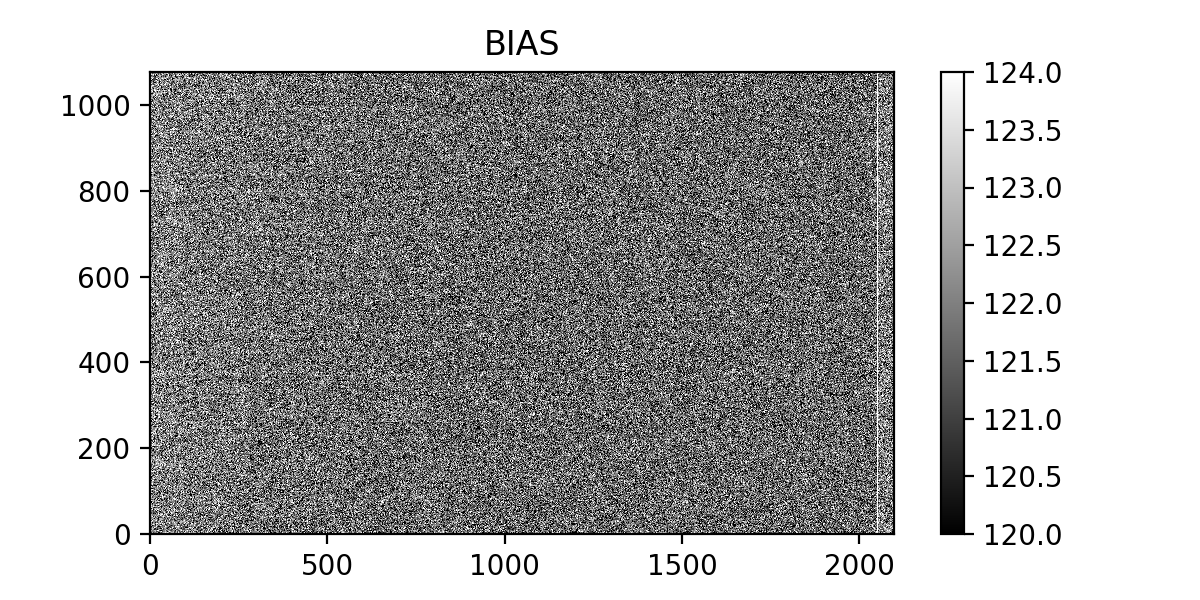

In [27]:
plt.figure(figsize=(6,3))
plt.imshow(BIAS, origin='lower', aspect='auto', cmap=plt.cm.gray)
plt.title('BIAS')
plt.clim(np.percentile(BIAS, (5, 98)))
cb = plt.colorbar()

In [28]:
Flist = []

for k in range(len(flatfiles)):
    img = CCDData.read(dir + flatfiles['impath'][k], unit=u.adu)

    # subtract the bias, put in units of ADU/s
    img.data = (img.data - BIAS) / (img.header['EXPTIME'])
    img.unit = img.unit / u.s

    # trim off bias section
    img = trim_image(img, fits_section=img.header['DATASEC'])

    #  normalize each flat by its median
    img.data = img.data / np.nanmedian(img.data)

    Flist.append(img)

medflat = Combiner(Flist).median_combine()
print(medflat.shape)

(1028, 2048)


<IPython.core.display.Javascript object>


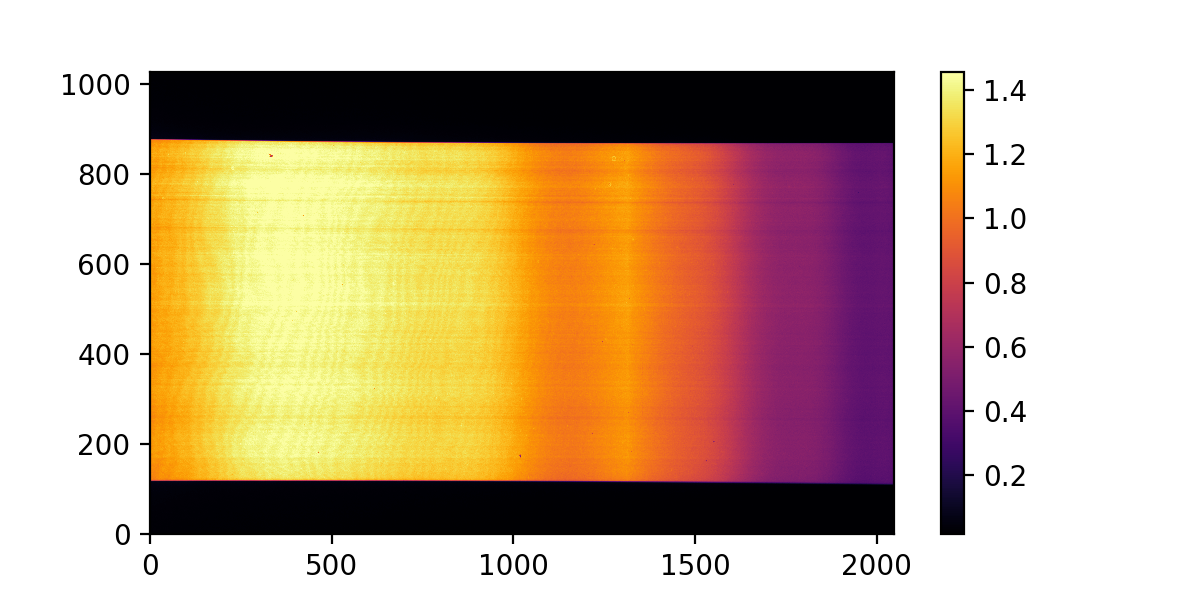

In [29]:
plt.figure(figsize=(6,3))
plt.imshow(medflat, origin='lower', aspect='auto', cmap=plt.cm.inferno)
plt.clim(np.percentile(medflat, (5, 98)))
cb = plt.colorbar()

Now we get to the `specreduce` part: normalize out the spectral response, found by averaging the spatial dimension together, and dividing out

In [30]:
ilum = ft.find_illum(medflat)

FLAT = ft.flat_response(medflat[ilum, :], smooth=False)

<IPython.core.display.Javascript object>


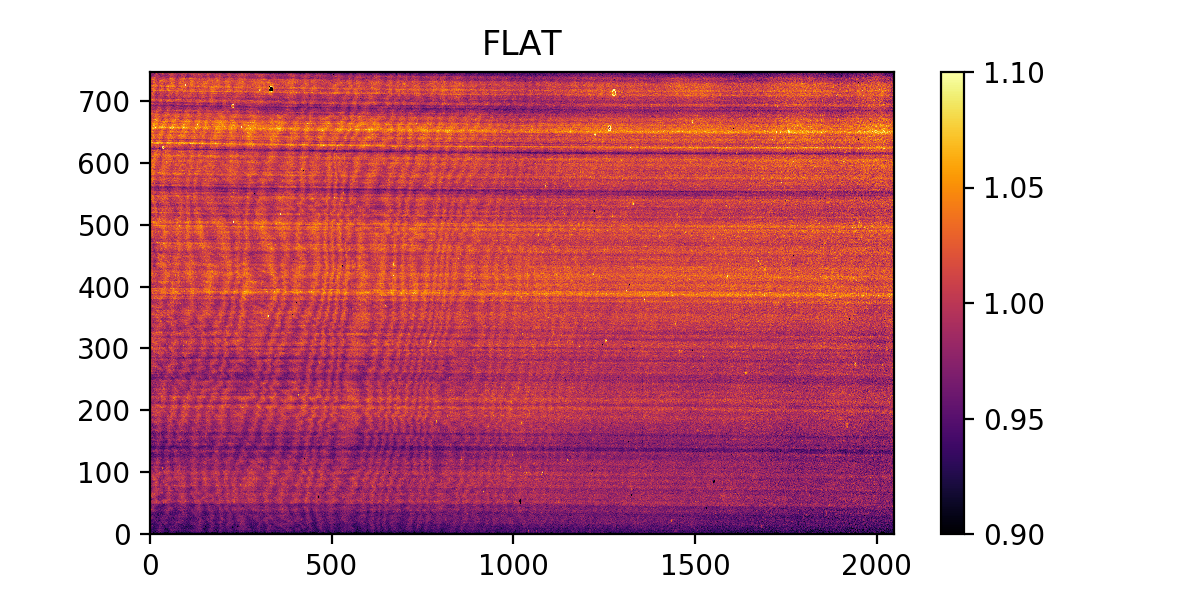

In [31]:
plt.figure(figsize=(6,3))
plt.imshow(FLAT, origin='lower', aspect='auto', cmap=plt.cm.inferno)
plt.clim(.9,1.1)
plt.title('FLAT')
cb = plt.colorbar()

In [32]:
medflat[ilum,:].unit

Unit("adu / s")

In [33]:
type(FLAT)

numpy.ma.core.MaskedArray

**ISSUE:** I'm losing my units in the creation of the FLAT

## 2. Trace & Extract

In [57]:
sci = '../../pydis_example/apo05/05may31.0010r.fits' # spectrum of the one target star, Gl 669A
sciimg = CCDData.read(sci, unit=u.adu)
# BASIC REDUCTION:
# subtract BIAS, divide FLAT, ExpTime, put in units of ADU/s

sciimg.data = (sciimg.data - BIAS) / (sciimg.header['EXPTIME'])
sciimg.unit = sciimg.unit / u.s

# trim off bias section
sciimg = trim_image(sciimg, fits_section=sciimg.header['DATASEC'])
# Now remove FLAT from ilum section
sciimg.data[ilum,:] = sciimg.data[ilum,:] / FLAT


fcal = '../../pydis_example/apo05/05may31.0020r.fits' # Flux std star observation, BD+282411
calimg = CCDData.read(fcal, unit=u.adu)
calimg.data = (calimg.data - BIAS) / (calimg.header['EXPTIME'])
calimg.unit = calimg.unit / u.s

# trim off bias section
calimg = trim_image(calimg, fits_section=calimg.header['DATASEC'])
# Now remove FLAT from ilum section
calimg.data[ilum,:] = calimg.data[ilum,:] / FLAT

In [58]:
sciimg.shape

(1028, 2048)

<IPython.core.display.Javascript object>


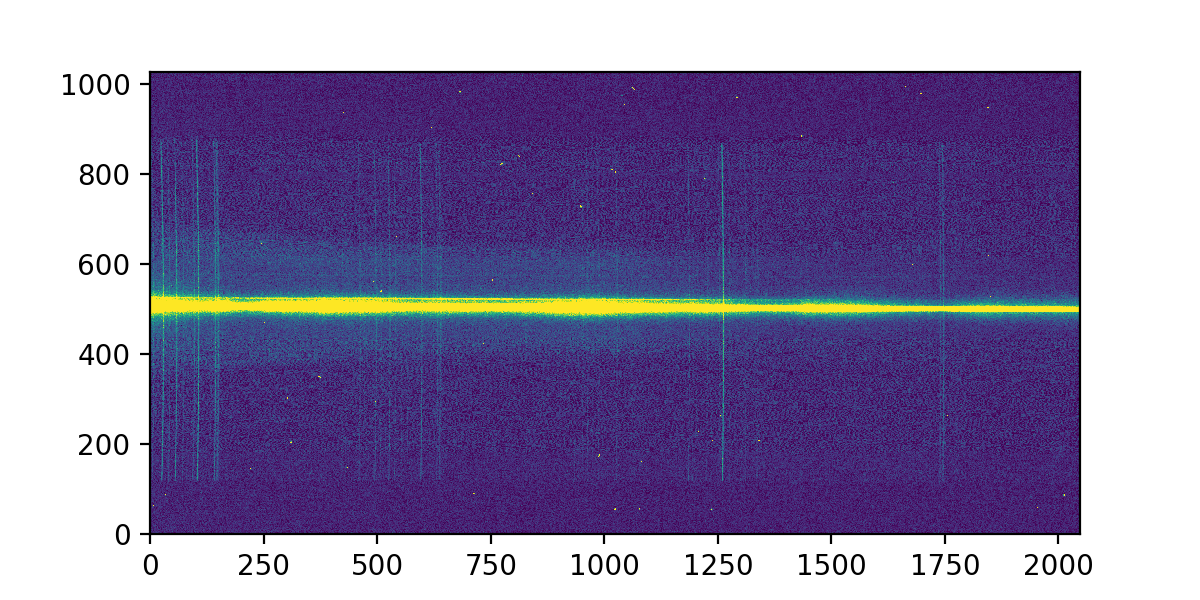

In [63]:
plt.figure(figsize=(6,3))
plt.imshow(sciimg, origin='lower', aspect='auto')
plt.clim(np.percentile(sciimg, (5, 98)))

/Users/james/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


<IPython.core.display.Javascript object>


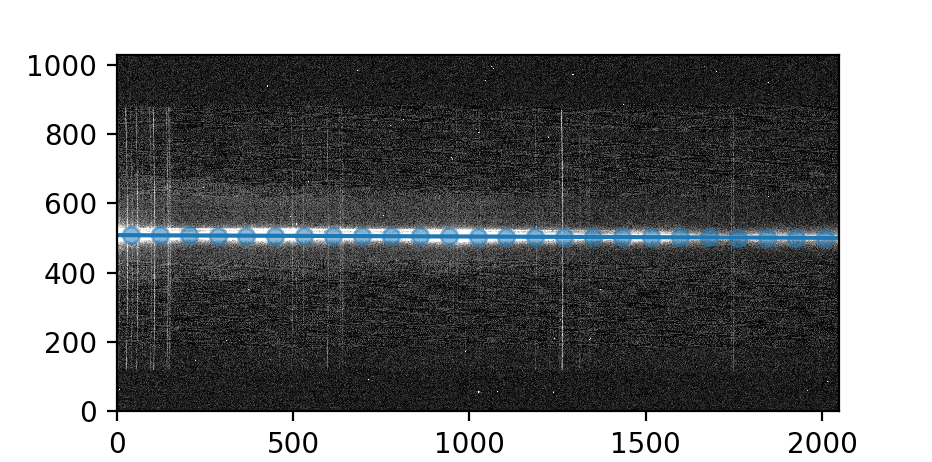

/Users/james/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [73]:
# Do the trace for both the Science image and the Flux Calibration images
sci_tr = ap.trace(sciimg, display=True, nbins=25)
cal_tr = ap.trace(calimg, display=False, nbins=25)


<IPython.core.display.Javascript object>


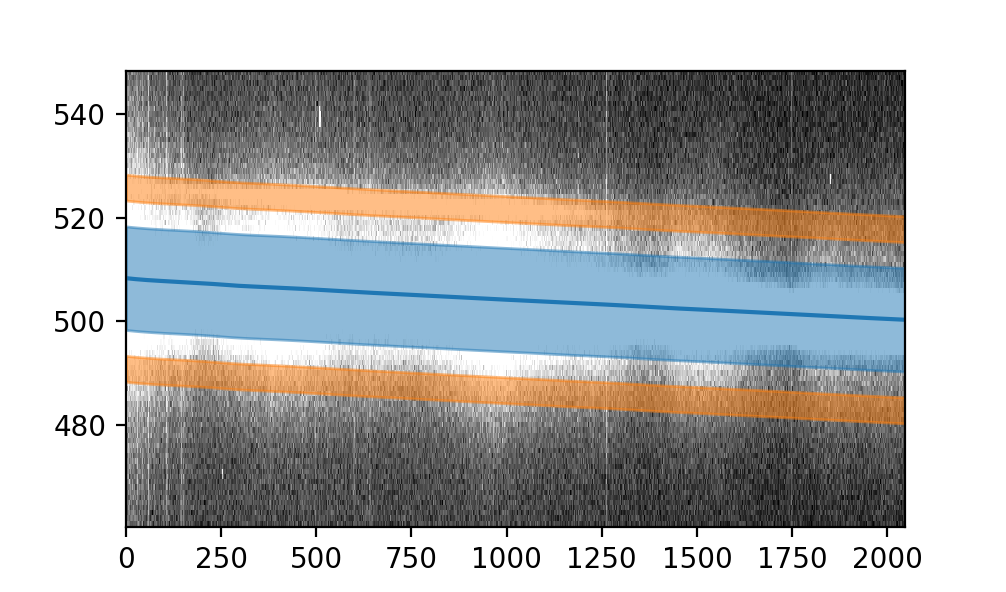

In [72]:
# Extraction of the spectrum along the trace for both the Science and Flux Cal images
sci_ex = ap.extract(sciimg, sci_tr, display=True, apwidth=10, skysep=5, skywidth=5)
cal_ex = ap.extract(calimg, cal_tr, display=False, apwidth=10, skysep=5, skywidth=5)

## 3. Wavelength Calibration

In [79]:
lamp = '../../pydis_example/apo05/05may31.0035r.fits' # HeNeAr lamp

arcimg = CCDData.read(lamp, unit=u.adu)
# put in units of ADU/s
arcimg.data = arcimg.data / (arcimg.header['EXPTIME'])
arcimg.unit = arcimg.unit / u.s

# trim off bias section
arcimg = trim_image(arcimg, fits_section=arcimg.header['DATASEC'])

In [80]:
# this data comes from the APO DIS red channel, which has wavelength axis backwards
# (despite not mentioning in the header)
wapprox = (np.arange(sciimg.shape[1]) - sciimg.shape[1]/2)[::-1] * sciimg.header['DISPDW'] + sciimg.header['DISPWC']

wapprox = wapprox * u.angstrom

In [81]:
# now we need to extract the trace from the Arc lamp image to get proper wavelength calibration
arc_sci_ex = ap.extract(arcimg, sci_tr, display=False, apwidth=10, skysep=5, skywidth=5)
arc_cal_ex = ap.extract(arcimg, cal_tr, display=False, apwidth=10, skysep=5, skywidth=5)

../apextract.py:287: RuntimeWarning: invalid value encountered in sqrt
  (N_A + N_A**2. / N_B) * (sigB**2.))


<IPython.core.display.Javascript object>


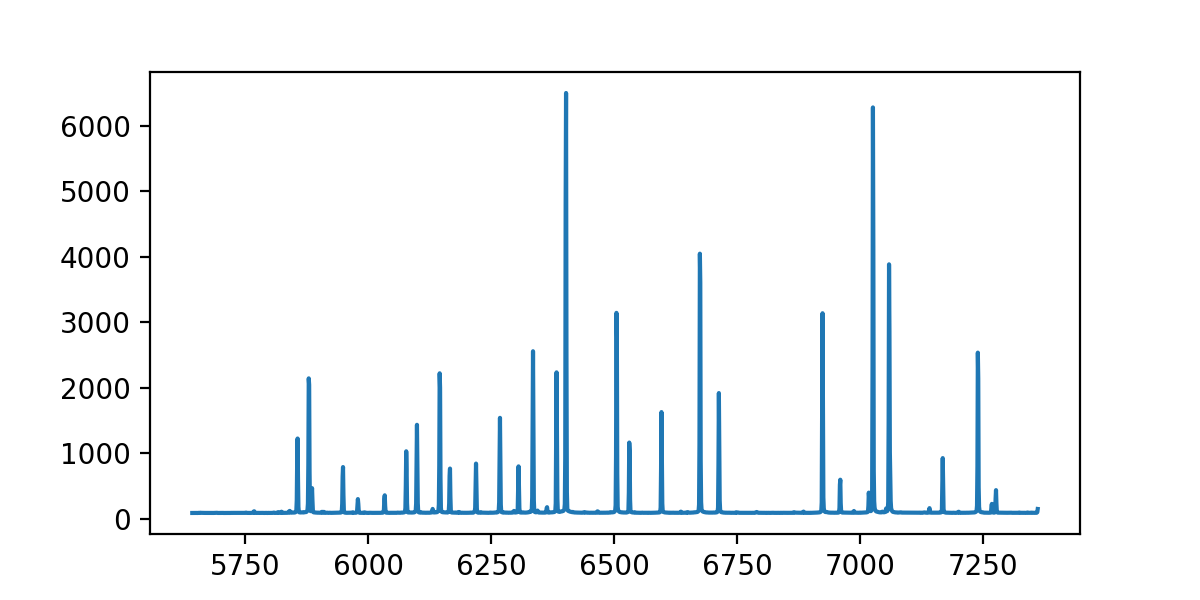

In [84]:
plt.figure(figsize=(6,3))
plt.plot(wapprox, arc_sci_ex['flux'])

In [85]:
# a simple table of prominent HeNeAr lines for the instrument in question
apo_henear = Table.read('../../pydis_example/apohenear.dat', 
                        format='ascii', names=('wave',))

In [88]:
sci_wave = iden.identify(wapprox.value, arc_sci_ex['flux'], identify_mode='nearest', 
                         fit_mode='spline', autotol=5, linewave=apo_henear['wave'])

cal_wave = iden.identify(wapprox.value, arc_cal_ex['flux'], identify_mode='nearest', 
                         fit_mode='spline', autotol=5, linewave=apo_henear['wave'])

Mode='nearest': 19 lines matched.
Mode='nearest': 19 lines matched.


**ISSUE:** `identify` will crash if the input wavelength object has units.

**ISSUE:** `identify` is not returning the wavelength units properly

## 4. Airmass & Flux Calibration

In [105]:
# Select the Std Star reference spectrum from the provided "onedstd" library
stdstar = fc.onedstd('spec50cal/bd284211.dat')

# Select the observatory-specific airmass extinction profile from the provided "extinction" library
Xfile = fc.obs_extinction('apoextinct.dat')

In [106]:
cal_flux = cal_ex['flux'] - cal_ex['skyflux']
cal_spectrum = Spectrum1D(spectral_axis=cal_wave * u.AA, 
                          flux=cal_flux.quantity, 
                          uncertainty=StdDevUncertainty(cal_ex['fluxerr']))

sci_flux = sci_ex['flux'] - sci_ex['skyflux']
sci_spectrum = Spectrum1D(spectral_axis=sci_wave * u.AA, 
                          flux=sci_flux.quantity, 
                          uncertainty=StdDevUncertainty(sci_ex['fluxerr']))

In [107]:
# Get the airmass from the Headers
ZD = sciimg.header['ZD'] / 180.0 * np.pi
sci_airmass = 1.0/np.cos(ZD) # approximate Zenith Distance -> Airmass conversion

ZD = calimg.header['ZD'] / 180.0 * np.pi
cal_airmass = 1.0/np.cos(ZD)

print(sci_airmass, cal_airmass)

1.0668455410852924 1.052300816491183


In [108]:
# actually apply the airmass corrections
cal_spectrum = fc.airmass_cor(cal_spectrum, cal_airmass, Xfile)

sci_spectrum = fc.airmass_cor(sci_spectrum, sci_airmass, Xfile)

In [110]:
# use a simple linear interpolation for the sensitivity function here
sensfunc = fc.standard_sensfunc(cal_spectrum, stdstar, display=False, mode='linear')

In [115]:
# this is the sensitivity function, which converts the CCD data from
# ADU/S -> erg/s/cm2/A
sensfunc['S'].unit

Unit("erg / (adu Angstrom cm2)")

In [123]:
# Finally, apply the sensfunc (created w/ the standard star) to our observed data
# which has slightly different wavelength units since the trace isn't identical, etc

final_spectrum = fc.apply_sensfunc(sci_spectrum, sensfunc)

final_spectrum.flux.unit

Unit("erg / (Angstrom cm2 s)")

In [140]:
final_spectrum.wavelength.value

array([7365.19653774, 7364.36969376, 7363.54280548, ..., 5641.45942088,
       5640.62972416, 5639.800069  ])

<IPython.core.display.Javascript object>


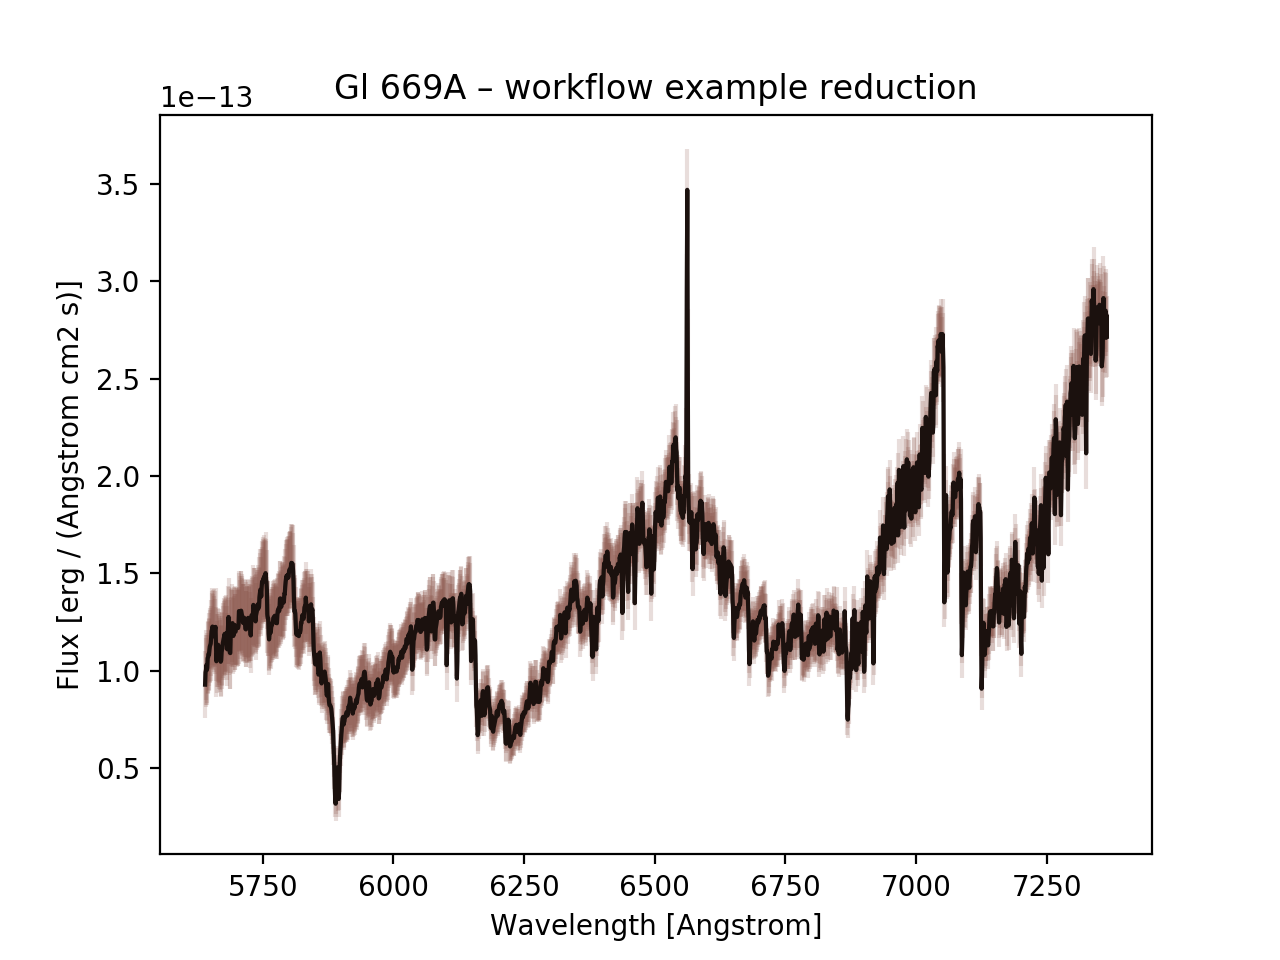

In [151]:
plt.plot(final_spectrum.wavelength, final_spectrum.flux, c='K')

# having to convert the Spectrum1D parameters like this is annoying
# and also inconsistent behavior with the uncertainty
plt.errorbar(final_spectrum.wavelength.value, final_spectrum.flux.value, 
             yerr=final_spectrum.uncertainty.array, alpha=0.2, c='C5')

plt.xlabel('Wavelength ['+str(final_spectrum.wavelength.unit)+']')
plt.ylabel('Flux ['+str(final_spectrum.flux.unit)+']')
plt.title('Gl 669A – workflow example reduction');

<IPython.core.display.Javascript object>


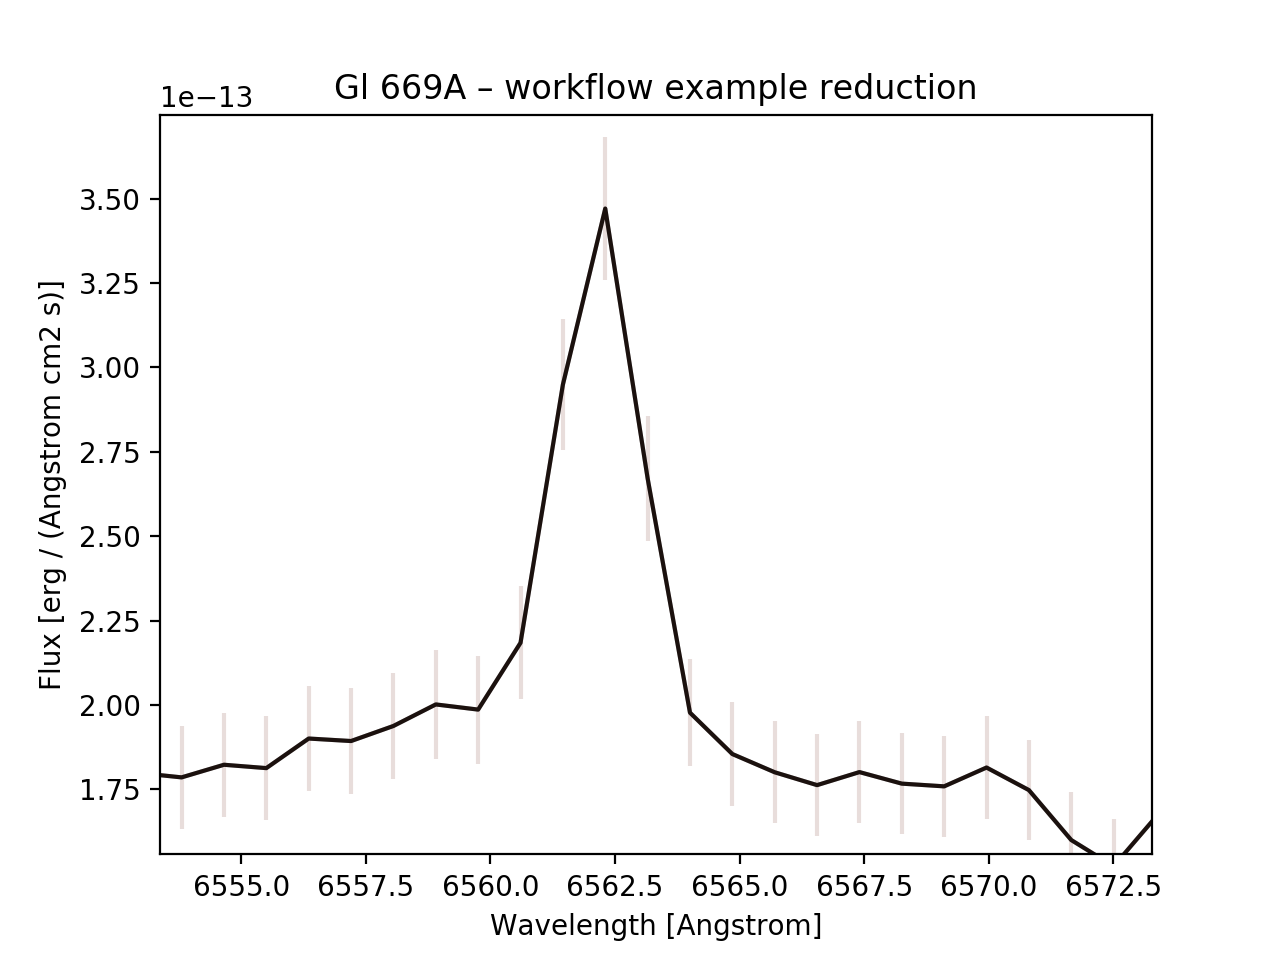

In [152]:
plt.plot(final_spectrum.wavelength, final_spectrum.flux, c='K')

plt.errorbar(final_spectrum.wavelength.value, final_spectrum.flux.value, 
             yerr=final_spectrum.uncertainty.array, alpha=0.2, c='C5')

plt.xlabel('Wavelength ['+str(final_spectrum.wavelength.unit)+']')
plt.ylabel('Flux ['+str(final_spectrum.flux.unit)+']')
plt.title('Gl 669A – workflow example reduction');

In [153]:
# things to add in:
# - cosmic rays
# - air2vac conversion

In [156]:
from specutils.utils.wcs_utils import air_to_vac

new_wave = air_to_vac(final_spectrum.wavelength)

<IPython.core.display.Javascript object>


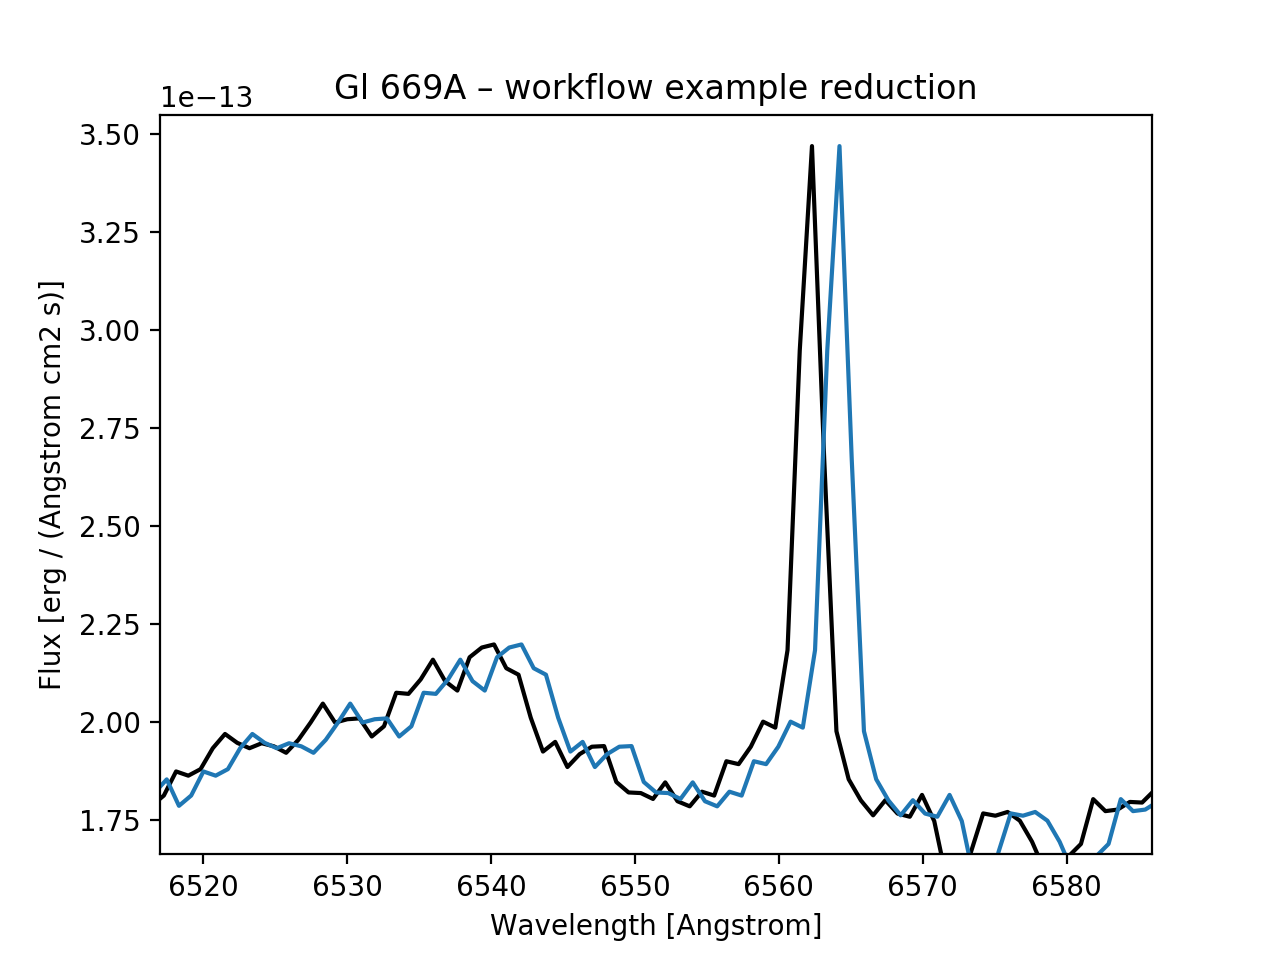

In [160]:
plt.plot(final_spectrum.wavelength, final_spectrum.flux, c='K')

plt.plot(new_wave, final_spectrum.flux, c='C0')

# plt.errorbar(new_wave.value, final_spectrum.flux.value, 
#              yerr=final_spectrum.uncertainty.array, alpha=0.2, c='C5')

plt.xlabel('Wavelength ['+str(final_spectrum.wavelength.unit)+']')
plt.ylabel('Flux ['+str(final_spectrum.flux.unit)+']')
plt.title('Gl 669A – workflow example reduction');

In [161]:
from ccdproc import cosmicray_lacosmic

<IPython.core.display.Javascript object>


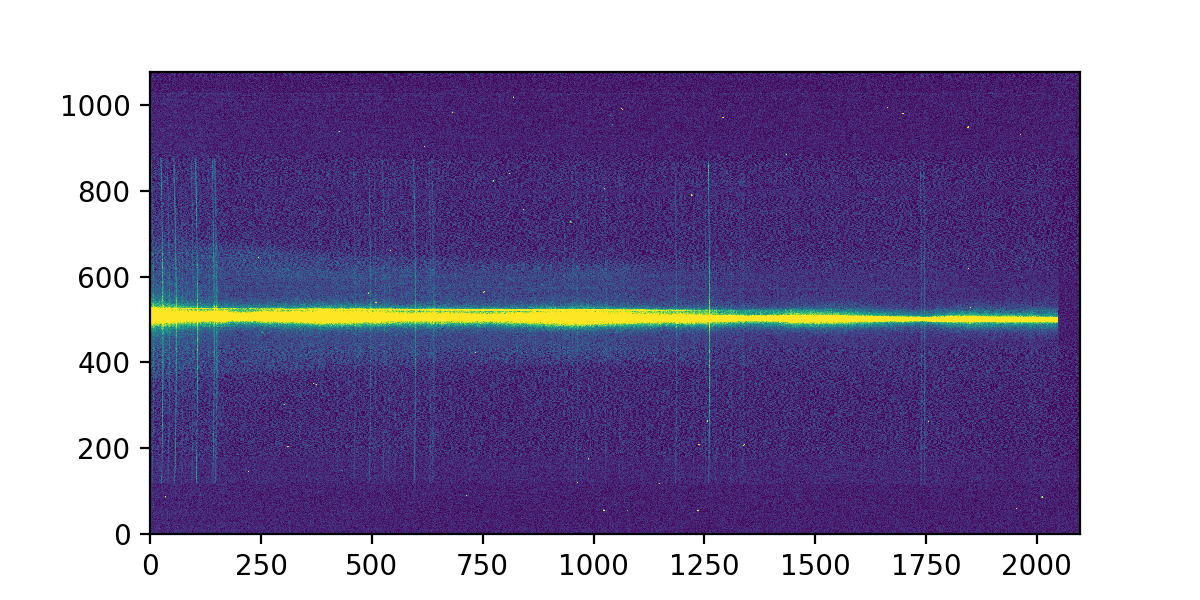

In [193]:
sci = '../../pydis_example/apo05/05may31.0010r.fits' # spectrum of the one target star, Gl 669A
sciimg_raw = CCDData.read(sci, unit=u.adu)

# Cosmic Rays should go HERE, before the basic reduction

plt.figure(figsize=(6,3))
plt.imshow(sciimg_raw, origin='lower', aspect='auto')
plt.clim(np.percentile(sciimg_raw, (5, 98)))

In [196]:
# If desired, this is how to easily do CR cleaning.
# It also will apply the gain, changing the img units from ADU/s to e-/s
# unless `gain_apply` is set to False
sciimg = cosmicray_lacosmic(sciimg_raw, gain=sciimg_raw.header['GAIN'] * u.electron / u.adu, 
                            readnoise=sciimg_raw.header['RDNOISE'] * u.electron, 
                            sigclip=6)


INFO:astropy:overwriting Masked Objects's current mask with specified mask.


INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


<IPython.core.display.Javascript object>


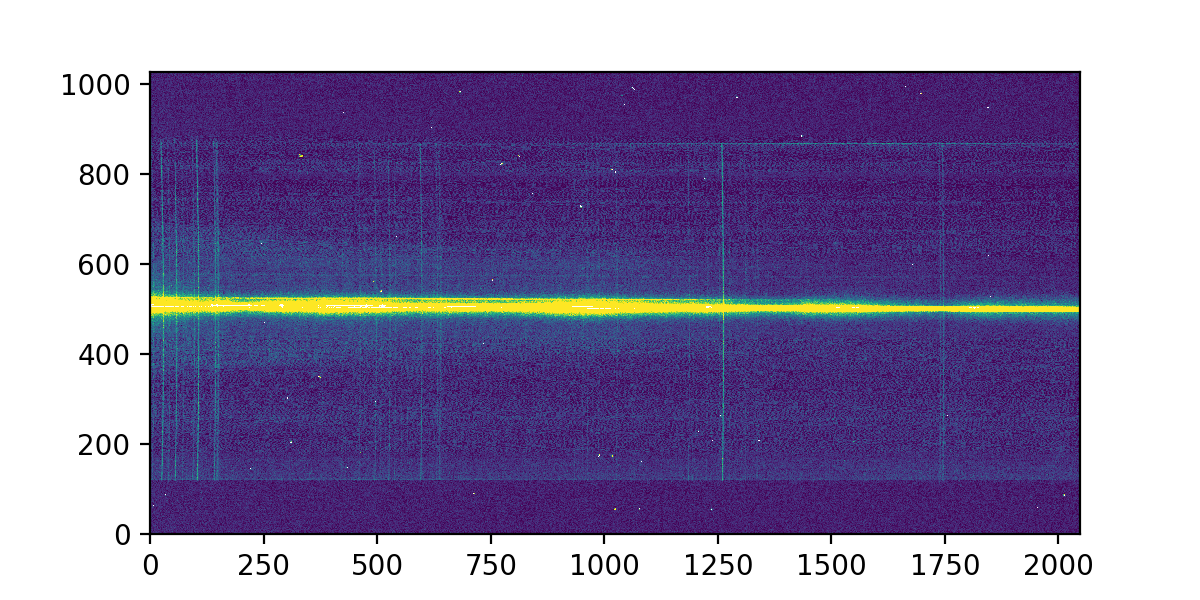

In [197]:
# BASIC REDUCTION then procedes like normal...
# subtract BIAS, divide FLAT, ExpTime, put in units of ADU/s
sciimg.data = (sciimg.data - BIAS) / (sciimg_raw.header['EXPTIME'])
sciimg.unit = sciimg.unit / u.s

# trim off bias section
sciimg = trim_image(sciimg, fits_section=sciimg_raw.header['DATASEC'])

# Now remove FLAT from illuminated section
sciimg.data[ilum,:] = sciimg.data[ilum,:] / FLAT


plt.figure(figsize=(6,3))
plt.imshow(sciimg, origin='lower', aspect='auto')
plt.clim(np.percentile(sciimg, (5, 98)))